In [0]:
#!pip uninstall tensorflow

In [0]:
#!pip install tensorflow-gpu

# Check for GPU Support

In [57]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Connect to Google Drive and access the dataset

In [58]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Load the X_train, X_test, Y_train, Y_test, X_val and Y_val datasets from the h5py file	

In [0]:
import h5py
filename = '/content/gdrive/My Drive/Colab Notebooks/dataset/svhn/SVHN_single_grey1.h5'

with h5py.File(filename, 'r') as f:
    # Get the data
    X_test = list(f['X_test'])
    X_train = list(f['X_train'])
    X_val = list(f['X_val'])
    y_val = list(f['y_val'])
    y_test = list(f['y_test'])
    y_train = list(f['y_train'])

#Flatten the images for Keras	& Normalize the inputs for X_train, X_test and X_val	

In [0]:
# Images data pre-processing
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.utils import to_categorical

X_train_scaled = [x/255 for x in X_train]
X_val_scaled = [x/255 for x in X_val]
X_test_scaled = [x/255 for x in X_test]

X_train_scaled = np.asarray(X_train_scaled)
X_val_scaled = np.asarray(X_val_scaled)
X_test_scaled = np.asarray(X_test_scaled)

X_train_scaled = X_train_scaled.reshape(len(X_train_scaled),32,32,1)
X_val_scaled = X_val_scaled.reshape(len(X_val_scaled),32,32,1)
X_test_scaled = X_test_scaled.reshape(len(X_test_scaled),32,32,1)

#Convert the class matrices Y_train, Y_test and Y_val into one hot vectors	

In [0]:
y_val_scaled = np.asarray(y_val)
y_test_scaled = np.asarray(y_test)
y_train_scaled = np.asarray(y_train)

y_val_scaled = to_categorical(y_val_scaled)
y_test_scaled = to_categorical(y_test_scaled)
y_train_scaled = to_categorical(y_train_scaled)

#Print the train, test and val shapes	

In [62]:
print ('Shape of training data is ({:},{:})'.format(len(X_train_scaled), len(y_train_scaled)))
print ('Shape of test data is ({:},{:})'.format(len(X_test_scaled), len(y_test_scaled)))
print ('Shape of validation data is ({:},{:})'.format(len(X_val_scaled), len(y_val_scaled)))

Shape of training data is (42000,42000)
Shape of test data is (18000,18000)
Shape of validation data is (60000,60000)


#Visualize the first 10 images in X_train and the corresponding Y_train labels	

Label is->2


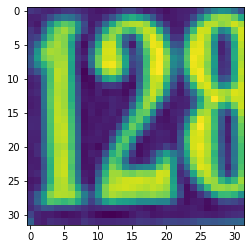

Label is->6


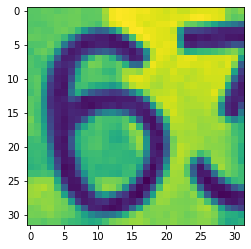

Label is->7


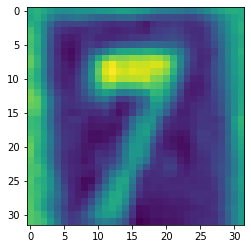

Label is->4


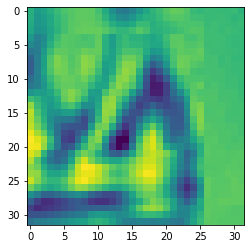

Label is->4


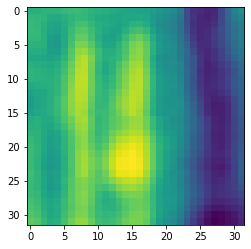

Label is->0


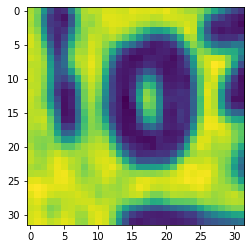

Label is->3


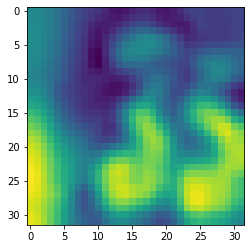

Label is->0


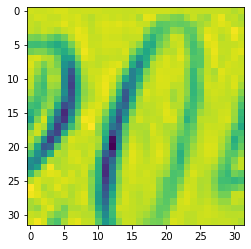

Label is->7


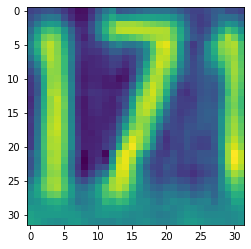

Label is->3


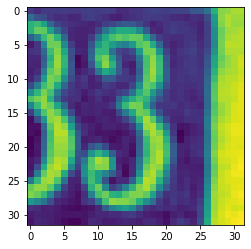

In [63]:
from matplotlib import pyplot as plt
%matplotlib inline

for i in range(10):
  print ('Label is->{:}'.format(y_train[i]))
  plt.imshow(X_train[i])
  plt.show()

#In the train and test loop, define the hyperparameters for the model	

In [0]:
# Lists to hold the Experiment details, acuracy and l2 regularization details for final comparision

In [0]:
model_description = []
model_accuracy = []
model_l2_regularization = []
model_lr = []
model_dropout = []

#Create a Sequential model in Keras with input layer with the correct input shape, Hidden Layers, Output Layers and the activation functions	

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras import regularizers
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.constraints import maxnorm

def build_model(l2_lambda=0.0001,
                learning_rate=0.01,
                dropout_rate=0.0
                ):

  l2 = None if l2_lambda is 0 else regularizers.l2(l2_lambda)

  if l2 is None:
    print ('Model is running without any L2 regularization')

  model = Sequential()
  model.add(Conv2D(64, (2,2), activation='relu', kernel_regularizer=l2, input_shape=(32,32,1)))
  model.add(MaxPooling2D(2,2))

  model.add(Conv2D(128, (2,2), activation='relu', kernel_regularizer=l2, ))
  model.add(MaxPooling2D(2,2))

  model.add(Flatten())

  model.add(Dropout(dropout_rate))

  model.add(Dense(10, activation='softmax'))

  model.summary()

  # create optimizer
  optimizer = Adam(lr=learning_rate)

  #Define the optimizer to be used in this model	
  #Compile the model with the corresponding Loss and metrics to monitor	
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  return model

# Create Model - Low Lambda Value

In [92]:
model_with_low_l2_lambda = build_model(0.001)

#Fit the model	
history = model_with_low_l2_lambda.fit(X_train_scaled, y_train_scaled, epochs=10, validation_data=(X_val_scaled,y_val_scaled))

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 31, 31, 64)        320       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 14, 14, 128)       32896     
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 6272)              0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 6272)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 10)              

#Visualizing Training Performance

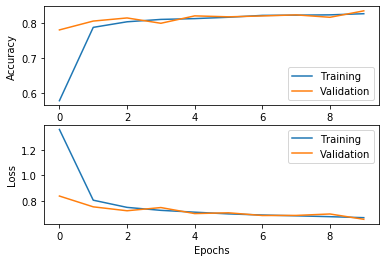

In [93]:
import matplotlib.pyplot as plt
%matplotlib inline

figure = plt.figure()

ax1 = figure.add_subplot(211)
ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(labels=['Training','Validation'])

ax1 = figure.add_subplot(212)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(labels=['Training','Validation'])

plt.show()

#Low Lambda Model - Use model.evaluate() to return the score	

In [103]:
scores = model_with_low_l2_lambda.evaluate(X_test_scaled, y_test_scaled)
m1_accuracy = model_with_low_l2_lambda.metrics_names[1], scores[1]*100
print("%s: %.2f%%" % (m1_accuracy))

model_description.append('Model 1->Low L2 Lambda')
model_accuracy.append(m1_accuracy)
model_l2_regularization.append(.0001)
model_lr.append("None")
model_dropout.append("None")

18000/18000 [==============================] - 1s 79us/step
acc: 82.01%


#Disable Regularization by setting appropriate value for Lambda and check the loss of the NN	

In [95]:
model_without_l2_lambda = build_model(0)

#Fit the model	
history = model_without_l2_lambda.fit(X_train_scaled, y_train_scaled, epochs=10, validation_data=(X_val_scaled,y_val_scaled))

Model is running without any L2 regularization
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 31, 31, 64)        320       
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 14, 14, 128)       32896     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 6272)              0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 6272)              0         
_________________________________________________________________
dense_

# Zero Regularization - Use model.evaluate() to return the score


In [104]:
scores = model_without_l2_lambda.evaluate(X_test_scaled, y_test_scaled)
m2_accuracy = model_without_l2_lambda.metrics_names[1], scores[1]*100
print("%s: %.2f%%" % (m1_accuracy))

model_description.append('Model 2->Zero L2 Lambda')
model_accuracy.append(m2_accuracy)
model_l2_regularization.append(0)
model_lr.append("None")
model_dropout.append("None")

18000/18000 [==============================] - 1s 72us/step
acc: 82.01%


#Increase the Regularization parameter (Lambda) and check how the loss is for the NN. Record findings		

In [97]:
model_with_high_l2_lambda = build_model(0.05)

#Fit the model	
history = model_with_high_l2_lambda.fit(X_train_scaled, y_train_scaled, epochs=10, validation_data=(X_val_scaled,y_val_scaled))

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 31, 31, 64)        320       
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 14, 14, 128)       32896     
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 6272)              0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 6272)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 10)              

#High Regularization - Use model.evaluate() to return the score


In [105]:
scores = model_with_high_l2_lambda.evaluate(X_test_scaled, y_test_scaled)
m3_accuracy = model_with_high_l2_lambda.metrics_names[1], scores[1]*100
print("%s: %.2f%%" % (m1_accuracy))

model_description.append('Model 3->High L2 Lambda')
model_accuracy.append(m3_accuracy)
model_l2_regularization.append(0.05)
model_lr.append("None")
model_dropout.append("None")

18000/18000 [==============================] - 1s 72us/step
acc: 82.01%


# Hyper Parameter Tuning Using GridSearch 

In [90]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import time

# define the grid search parameters
learn_rate = [0.001,0.005,0.01,0.1]
dropout_rate = [0.0,0.2,0.3]
l2_lambda=[0.001,0.05,0.1]

param_grid = dict(l2_lambda=l2_lambda,
                  learning_rate=learn_rate,
                  dropout_rate=dropout_rate)

t0 = time.time()

# create model
model = KerasClassifier(build_fn=build_model, epochs=3, verbose=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_train_scaled, y_train_scaled)

t1 = time.time()

print ('\nTotal time taken is {:} sec'.format(t1-t0))

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 31, 31, 64)        320       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 14, 14, 128)       32896     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 6272)              0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 6272)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 10)              

In [107]:
# Hyper parameter tuning summarize results
print("\n\nBest: %f using %s \n" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))



Best: 0.801262 using {'dropout_rate': 0.0, 'l2_lambda': 0.001, 'learning_rate': 0.01} 

0.798929 (0.009703) with: {'dropout_rate': 0.0, 'l2_lambda': 0.001, 'learning_rate': 0.001}
0.799571 (0.004532) with: {'dropout_rate': 0.0, 'l2_lambda': 0.001, 'learning_rate': 0.005}
0.801262 (0.008640) with: {'dropout_rate': 0.0, 'l2_lambda': 0.001, 'learning_rate': 0.01}
0.799357 (0.007733) with: {'dropout_rate': 0.0, 'l2_lambda': 0.001, 'learning_rate': 0.1}
0.099500 (0.002452) with: {'dropout_rate': 0.0, 'l2_lambda': 0.05, 'learning_rate': 0.001}
0.098690 (0.002469) with: {'dropout_rate': 0.0, 'l2_lambda': 0.05, 'learning_rate': 0.005}
0.101929 (0.000923) with: {'dropout_rate': 0.0, 'l2_lambda': 0.05, 'learning_rate': 0.01}
0.099143 (0.002864) with: {'dropout_rate': 0.0, 'l2_lambda': 0.05, 'learning_rate': 0.1}
0.100452 (0.002403) with: {'dropout_rate': 0.0, 'l2_lambda': 0.1, 'learning_rate': 0.001}
0.100452 (0.002403) with: {'dropout_rate': 0.0, 'l2_lambda': 0.1, 'learning_rate': 0.005}
0.09

# Results Comparision

#Set the best hyperparameters found in the previous step. Check the Network’s accuracy.	

In [108]:
final_model = build_model(l2_lambda = 0.001,
                          learning_rate = 0.01,
                          dropout_rate = 0.0)

#Fit the model	
history = final_model.fit(X_train_scaled, 
                          y_train_scaled, 
                          epochs=10, 
                          validation_data=(X_val_scaled,y_val_scaled))

scores = final_model.evaluate(X_test_scaled, y_test_scaled)
accuracy_final = final_model.metrics_names[1], scores[1]*100
print("%s: %.2f%%" % (accuracy_final))

model_description.append('Final Model')
model_accuracy.append(accuracy_final)
model_l2_regularization.append(0.001)
model_lr.append(0.01)
model_dropout.append(0.0)

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 31, 31, 64)        320       
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 14, 14, 128)       32896     
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 6272)              0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 6272)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 10)              

# Summary

In [111]:
import pandas as pd

results_df = pd.DataFrame(list(zip(model_description, 
                                   model_accuracy,
                                   model_l2_regularization,                                    
                                   model_lr,
                                   model_dropout)),
                          columns=['Description',                                   
                                   'Accuracy',
                                   'L2 Lambda',                                   
                                   'Learning Rate',
                                   'Dropout'])

print ('\n==============Final Results==========================')
print (results_df.head(5))




==============Final Results==========================
               Description                  Accuracy  ...  Learning Rate Dropout
0   Model 1->Low L2 Lambda  (acc, 82.00555555555556)  ...           None    None
1  Model 2->Zero L2 Lambda  (acc, 84.56666666666666)  ...           None    None
2  Model 3->High L2 Lambda               (acc, 9.55)  ...           None    None
3              Final Model  (acc, 83.46666666666667)  ...           0.01       0

[4 rows x 5 columns]
